# RNN-LSTM model for time series data
### 1. Import Python packages

In [1]:
import datetime, os, math, torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim # optimization algorithms
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### 2. Data Preprocessing
- Data wrangling, train-val-test split (you may want to go through the learning resource on using Pandas)

In [2]:
filename = "AirQuality22-23.csv"
df = pd.read_csv(os.getcwd()+"/"+filename) # 'df' stands for dataframe, a Pandas object

# convert each date string into Python datetime object
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y')) 

print(df.head(10)) # print the last few rows
print("total rows: {}".format(df.shape[0]))

        Date    AQI  Air particles Humidity  Temperature Location  AQI.1  \
0 2022-09-16  163.0         6942.0       75%         20C   Atrium   98.0   
1 2022-09-23   38.0         1658.0       74%         19C   Atrium   48.0   
2 2022-09-30   48.0         1290.0       71%         19C   Atrium   56.0   
3 2022-10-07   53.0         1100.0       70%         19C   Atrium   56.0   
4 2022-10-14   35.0         1528.0       71%         20C   Atrium   49.0   
5 2022-10-21   40.0         1084.0       69%         20C   Atrium   32.0   
6 2022-10-28  137.0         5500.0       74%         19C   Atrium  117.0   
7 2022-11-04   85.0         2362.0       78%         19C   Atrium   65.0   
8 2022-11-11    NaN            NaN       NaN         NaN      NaN    NaN   
9 2022-11-18   38.0          794.0       70%         19C   Atrium   38.0   

   Air Particles Humidity Location.1  
0         4852.0      NaN      Music  
1         1943.0      NaN      Music  
2         1423.0      NaN      Music  
3      

In [3]:
# Split dataset on a 70-30 ratio for training, validation and testing
sample = df['AQI']
values = sample.values
print(values)

[163.  38.  48.  53.  35.  40. 137.  85.  nan  38.  52.  46.  nan  nan
  nan  nan  55.  62.  54.  78.  82.  28.  25.  36.  33.  25.  60.  25.
  nan  nan  76.  83.  50.  nan  nan  nan  nan  nan  33.]


In [4]:
# Alternative approach: use 2015 - 2020 as train years, 2021 as test year
train_yrs = [2018, 2019, 2020]
test_yrs = [2021]

# for yr in train_yrs:
#   train_set = df[df['Date'] > datetime.datetime(yr-1, 12, 31)]
#   train_set = df[df['Date'] < datetime.datetime(yr+1, 1, 1)]

train_set = df[df['Date'] > datetime.datetime(2017, 12, 31)]
train_set = train_set[train_set['Date'] < datetime.datetime(2021, 1, 1)]
train_set = train_set[train_set['Date'] != datetime.datetime(2020, 2, 29)] #exclude leap year

test_set = df[df['Date'] > datetime.datetime(2020, 12, 31)]
test_set = test_set[test_set['Date'] < datetime.datetime(2022, 1, 1)]
# for yr in test_yrs:
#   test_set = df[df['Date'] > datetime.datetime(yr-1, 12, 31)]
#   test_set = df[df['Date'] < datetime.datetime(yr+1, 1, 1)]
#   print(test_set.shape[0])

print("train_set: {} rows \ntest_set: {} rows \ntotal rows: {}".format(len(train_set), len(test_set),len(train_set)+len(test_set)))

train_set: 0 rows 
test_set: 0 rows 
total rows: 0


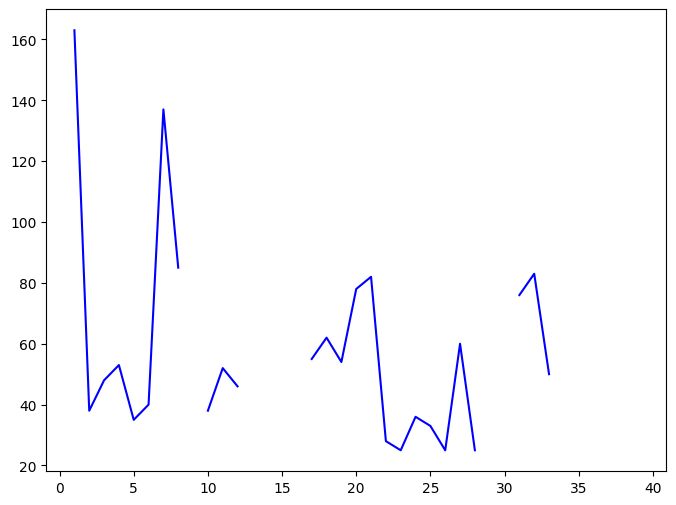

In [5]:
# Visualize data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([x for x in range(1,40)], values, c='blue')
#ax.axvspan(val_set['Date'].tolist()[0], val_set['Date'].tolist()[val_set.shape[0]-1], color="orange", alpha=0.3)
#ax.axvspan(test_set['Date'].tolist()[0], test_set['Date'].tolist()[test_set.shape[0]-1], color="red", alpha=0.3)

In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)

    return torch.tensor(X), torch.tensor(y)


lookback = 1
X_train, y_train = create_dataset(train_set['AQI'].tolist(), lookback=lookback)
#X_val, y_val = create_dataset(val_set['Flow (ML)'].tolist(), lookback=lookback)
X_test, y_test = create_dataset(test_set['AQI'].tolist(), lookback=lookback)
print(X_train.shape, y_train.shape)
#print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([0]) torch.Size([0])
torch.Size([0]) torch.Size([0])


### 3. Train and Validate RNN-LSTM Model
- See learning material on building LSTM Models for more details

In [8]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=5, num_classes=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [9]:
model = RNN_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 10000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

     #Validation
    if epoch % 1000 != 0:
      continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = math.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = math.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
import numpy as np
timeseries = df['Flow (ML)']
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_set.shape[0]] = y_pred

    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_set.shape[0]+lookback+1:len(timeseries)] = model(X_test)[:, -1]
# plot

lstm_out = [x for x in train_plot[:train_set.shape[0]]]
temp = [x for x in test_plot[train_set.shape[0]+lookback+1:len(timeseries)]]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['Date'].tolist(), df['Flow (ML)'].tolist(), c='blue')
ax.plot(df['Date'].tolist(), lstm_out+temp+[0,0], c='red')
# plt.plot(df['Flow (ML)'], c='b')
#print(train_plot.)
#plt.plot(test_plot, c='g')
plt.show()

In [ ]:
import numpy as np
timeseries = df['Flow (ML)']
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_set.shape[0]] = y_pred

    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_set.shape[0]+lookback+1:len(timeseries)] = model(X_test)[:, -1]
# plot

lstm_out = [x for x in train_plot[:train_set.shape[0]]]
temp = [x for x in test_plot[train_set.shape[0]+lookback+1:len(timeseries)]]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['Date'].tolist(), df['Flow (ML)'].tolist(), c='blue')
ax.plot(df['Date'].tolist(), lstm_out+temp+[0,0], c='red')
# plt.plot(df['Flow (ML)'], c='b')
#print(train_plot.)
#plt.plot(test_plot, c='g')
plt.show()